# DM-25018: Monthly May 2020 ap_pipe HiTS2015 reprocessing

### The HiTS dataset and AP Pipeline
As usual, I ran ap_pipe.py via slurm on the HiTS2015 dataset with HiTS2014 as templates. I did not create new templates, but used the ones I built in Jan 2020. The dataset consists of 3 fields (pointings), each revisited 28 times in 2015, in _g_ band. Two of the fields have a small overlap region.

The last step of ap_pipe is to save information about DIA Objects and DIA Sources in an Alert Production Database (APDB). I use this database to make some plots below. "Filtered" or "Good" means sources with one or more of the "bad," "saturated center," or "suspect" pixel flags have been excluded.

I ran this using the weekly build `w_2020_20`.

### More DIA Source and Objects than last month, but no cause for concern
Compared to April 2020 (which I believe was run with `w_2020_15`), there are significantly **more** DIA Objects, and moderately more DIA Sources.

One of the changes in this time involved the decorrelation afterburner in `ip_diffim` (DM-24371).  In the `ap_verify` metrics the AP team tracks in Chronograf, this correlated with a decrease in the total number of unassociated DIA Objects as well as changes in the ratio of DIA Sources to direct image sources for each CCD.

Another change in this time was a bug with Instrument Signature Removal that was later corrected (DM-24149). This appears to be responsible for the increase in the number of DIA Objects in a handful of CCDs near edges that have only 2--3 DIA Sources. These errant sources should disappear in the next (June) rerun.

Thanks to requests from Siegfried and Eric, I revisited plots from a number of months ago of the distribution of how bright DIA Sources are (both `totFlux` from the calexp and `psFlux` from the diffim), and added a couple plots showing how the number of DIA Sources varies with seeing. There was some discussion during the ap_pipe meeting on June 1 about whether the peaks at 0 are mostly garbage sources which could be thrown out, or more often dipoles which just haven't been subtracted cleanly. This is worthy of further investigation.

In [1]:
%matplotlib notebook

import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd

import lsst.daf.persistence as dafPersist

In [2]:
sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla

In [3]:
# Only if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)

<module 'apdbPlots' from '/project/mrawls/ap_pipe-notebooks/apdbPlots.py'>

In [4]:
repo = '/project/mrawls/hits2015/rerun/cw_2020_05'

In [5]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo)

<IPython.core.display.Javascript object>


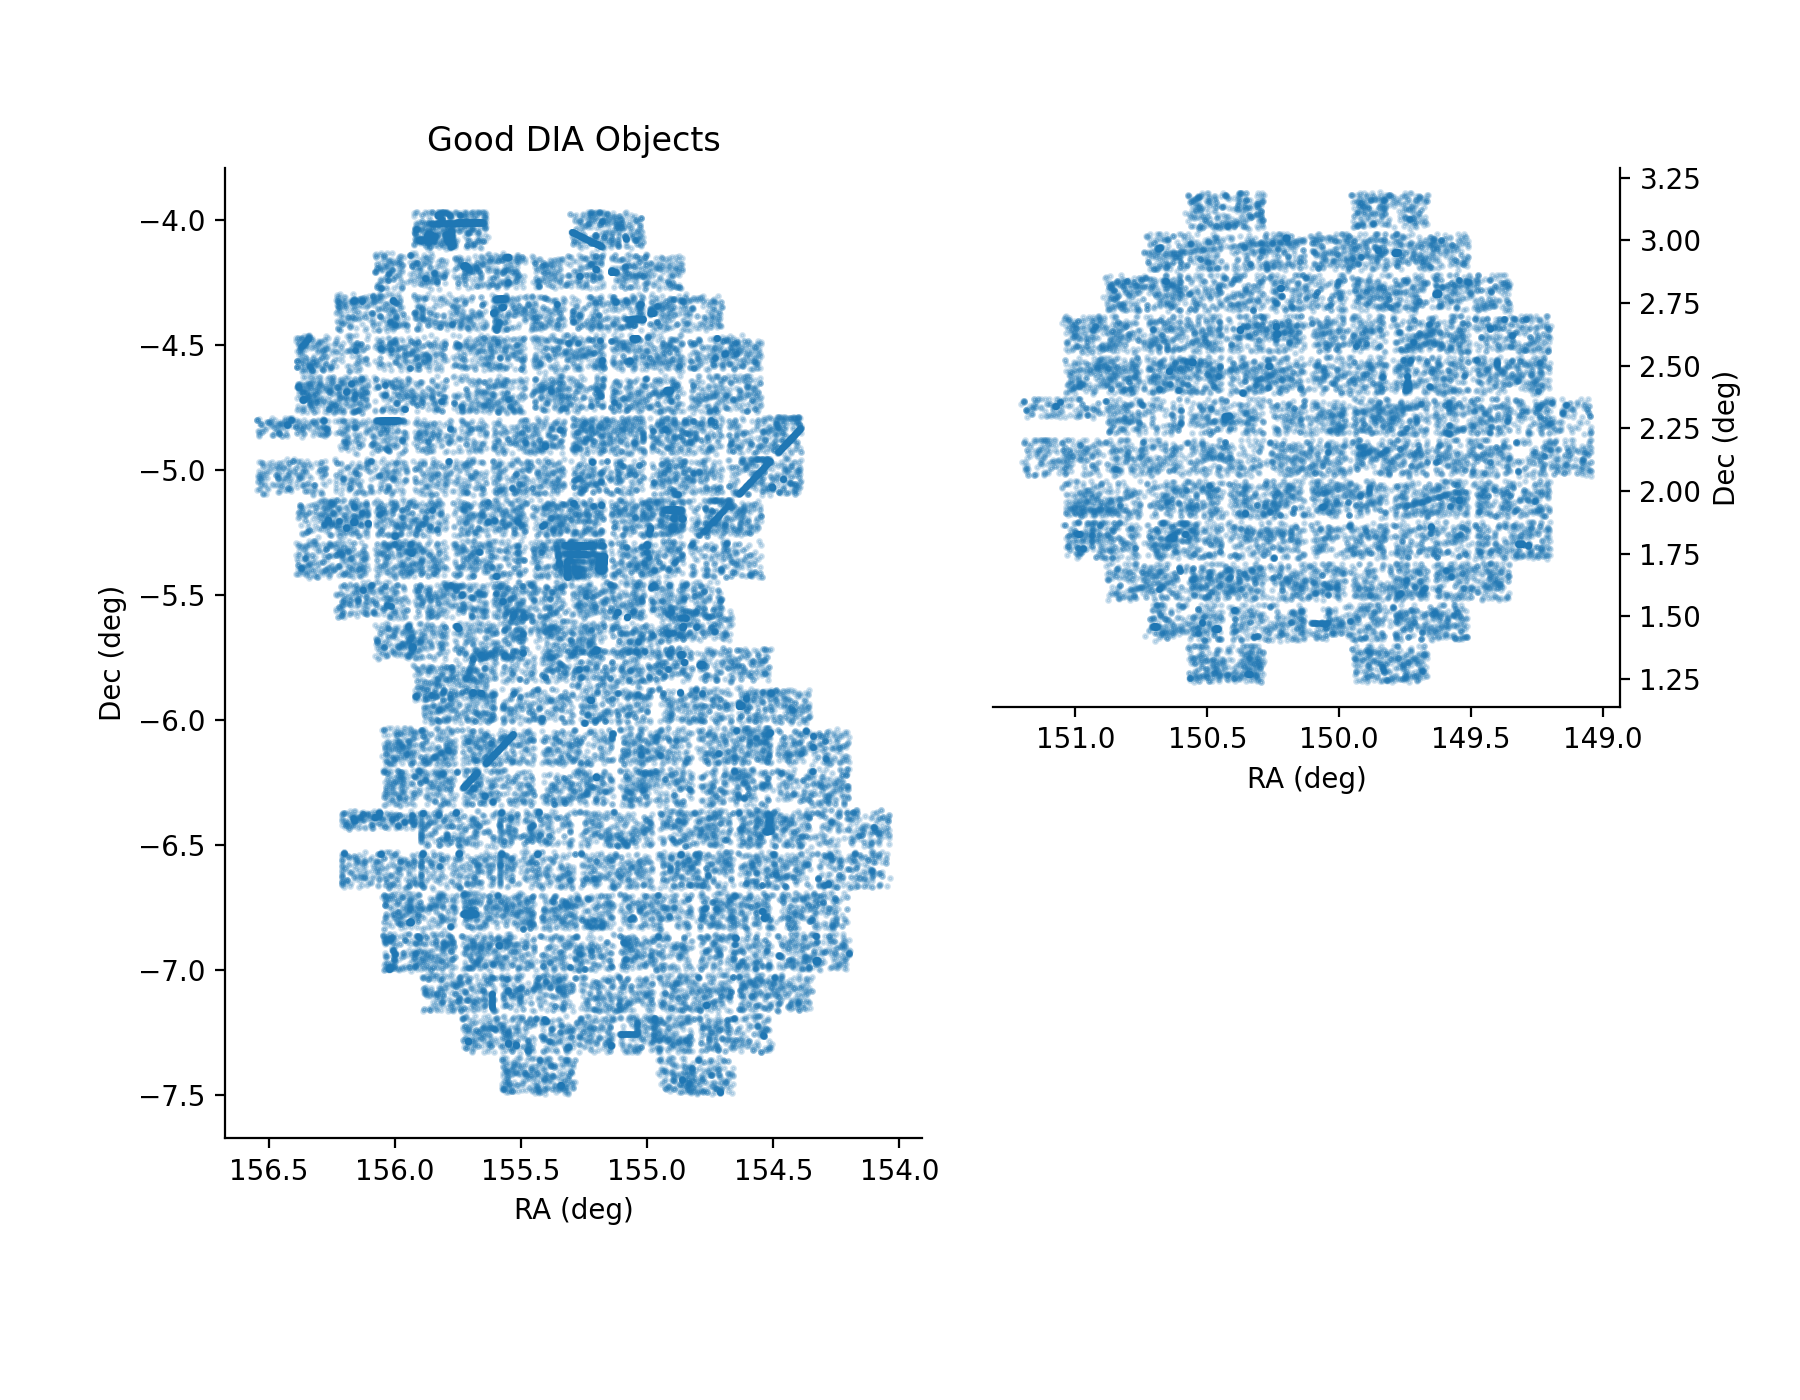

In [6]:
hitsPlot = pla.plotHitsSourcesOnSky(goodObj, title='Good DIA Objects')

<IPython.core.display.Javascript object>


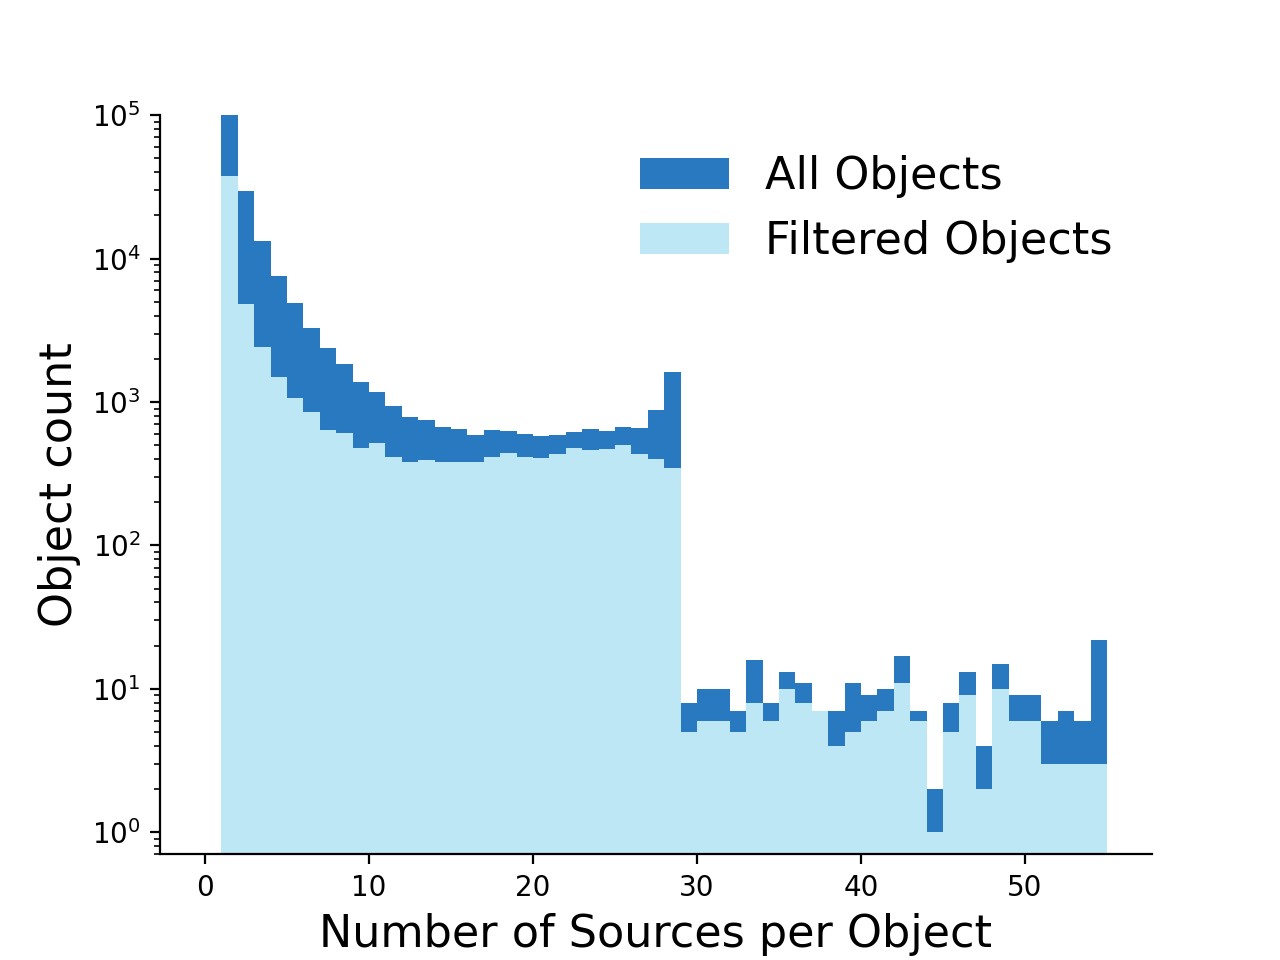

In [7]:
hist = doa.plotDiaObjectHistogram(objTable, goodObj)

<IPython.core.display.Javascript object>


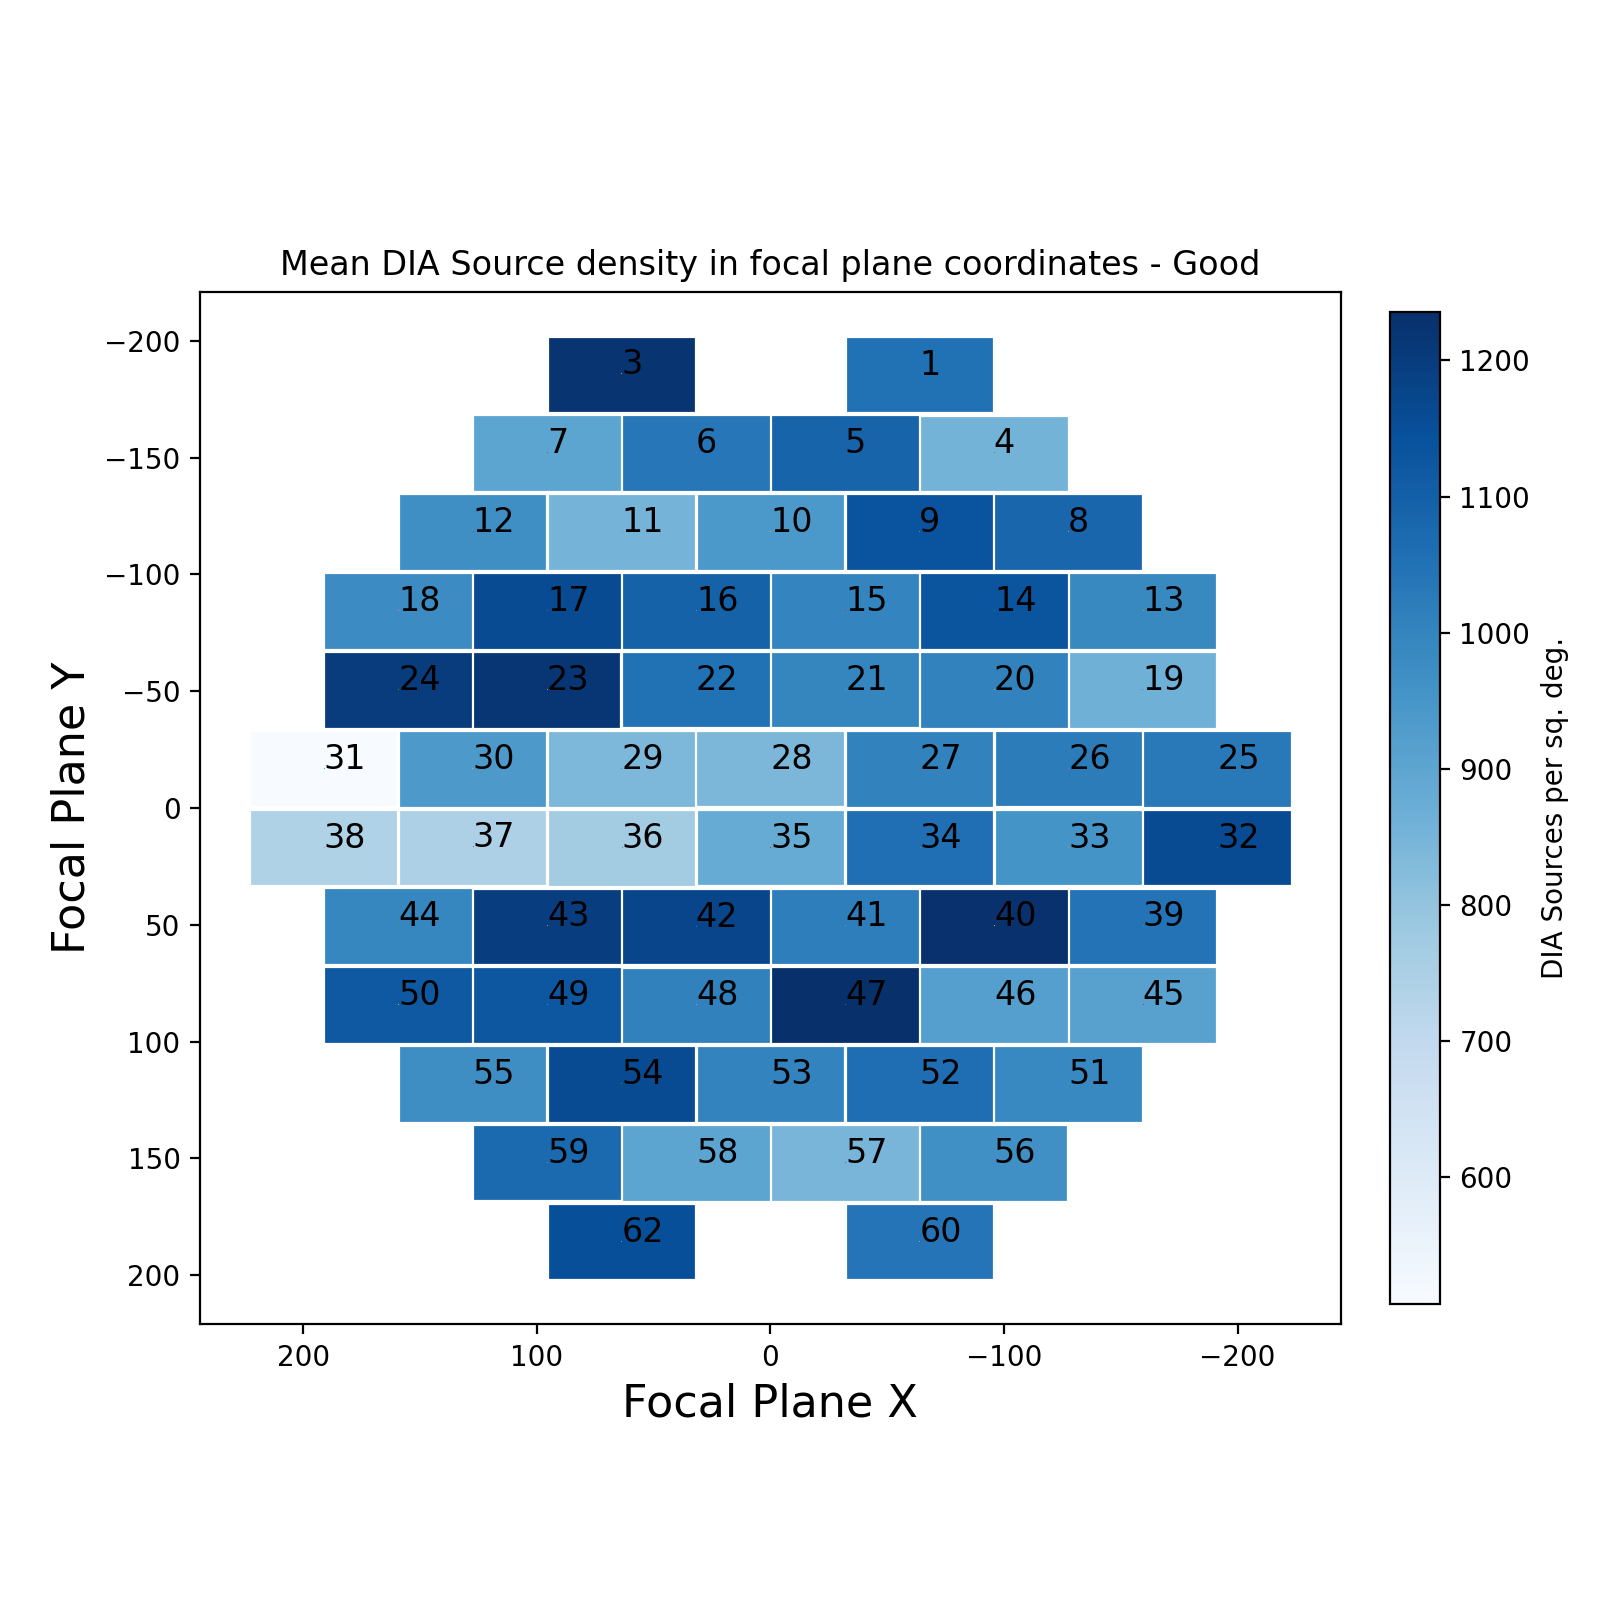

In [8]:
pla.plotDiaSourceDensityInFocalPlane(repo, goodSrc, title='- Good')

<IPython.core.display.Javascript object>


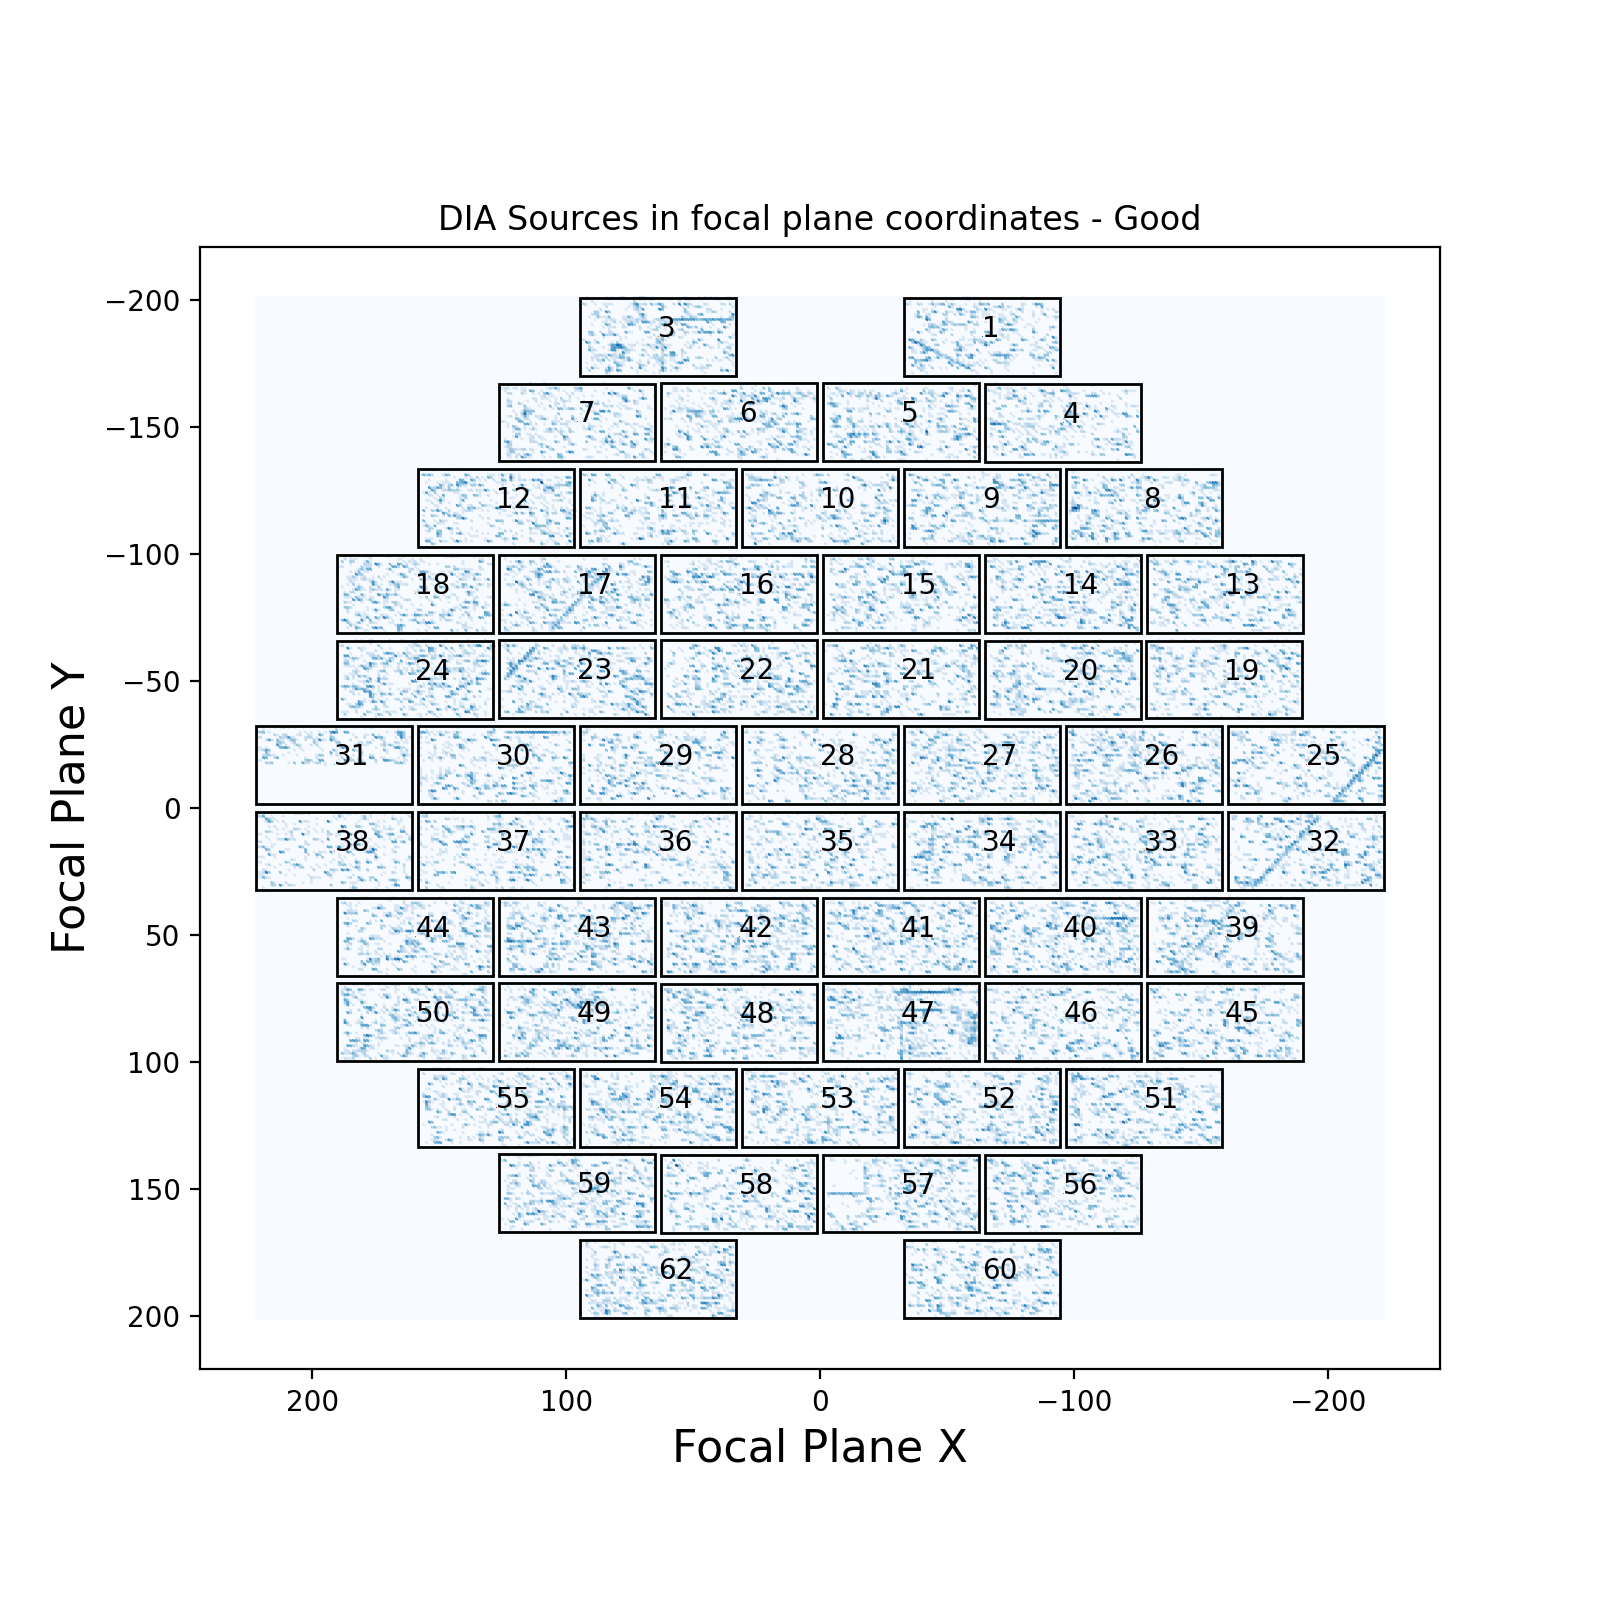

In [9]:
pla.plotDiaSourcesInFocalPlane(repo, goodSrc, title='- Good')

<IPython.core.display.Javascript object>


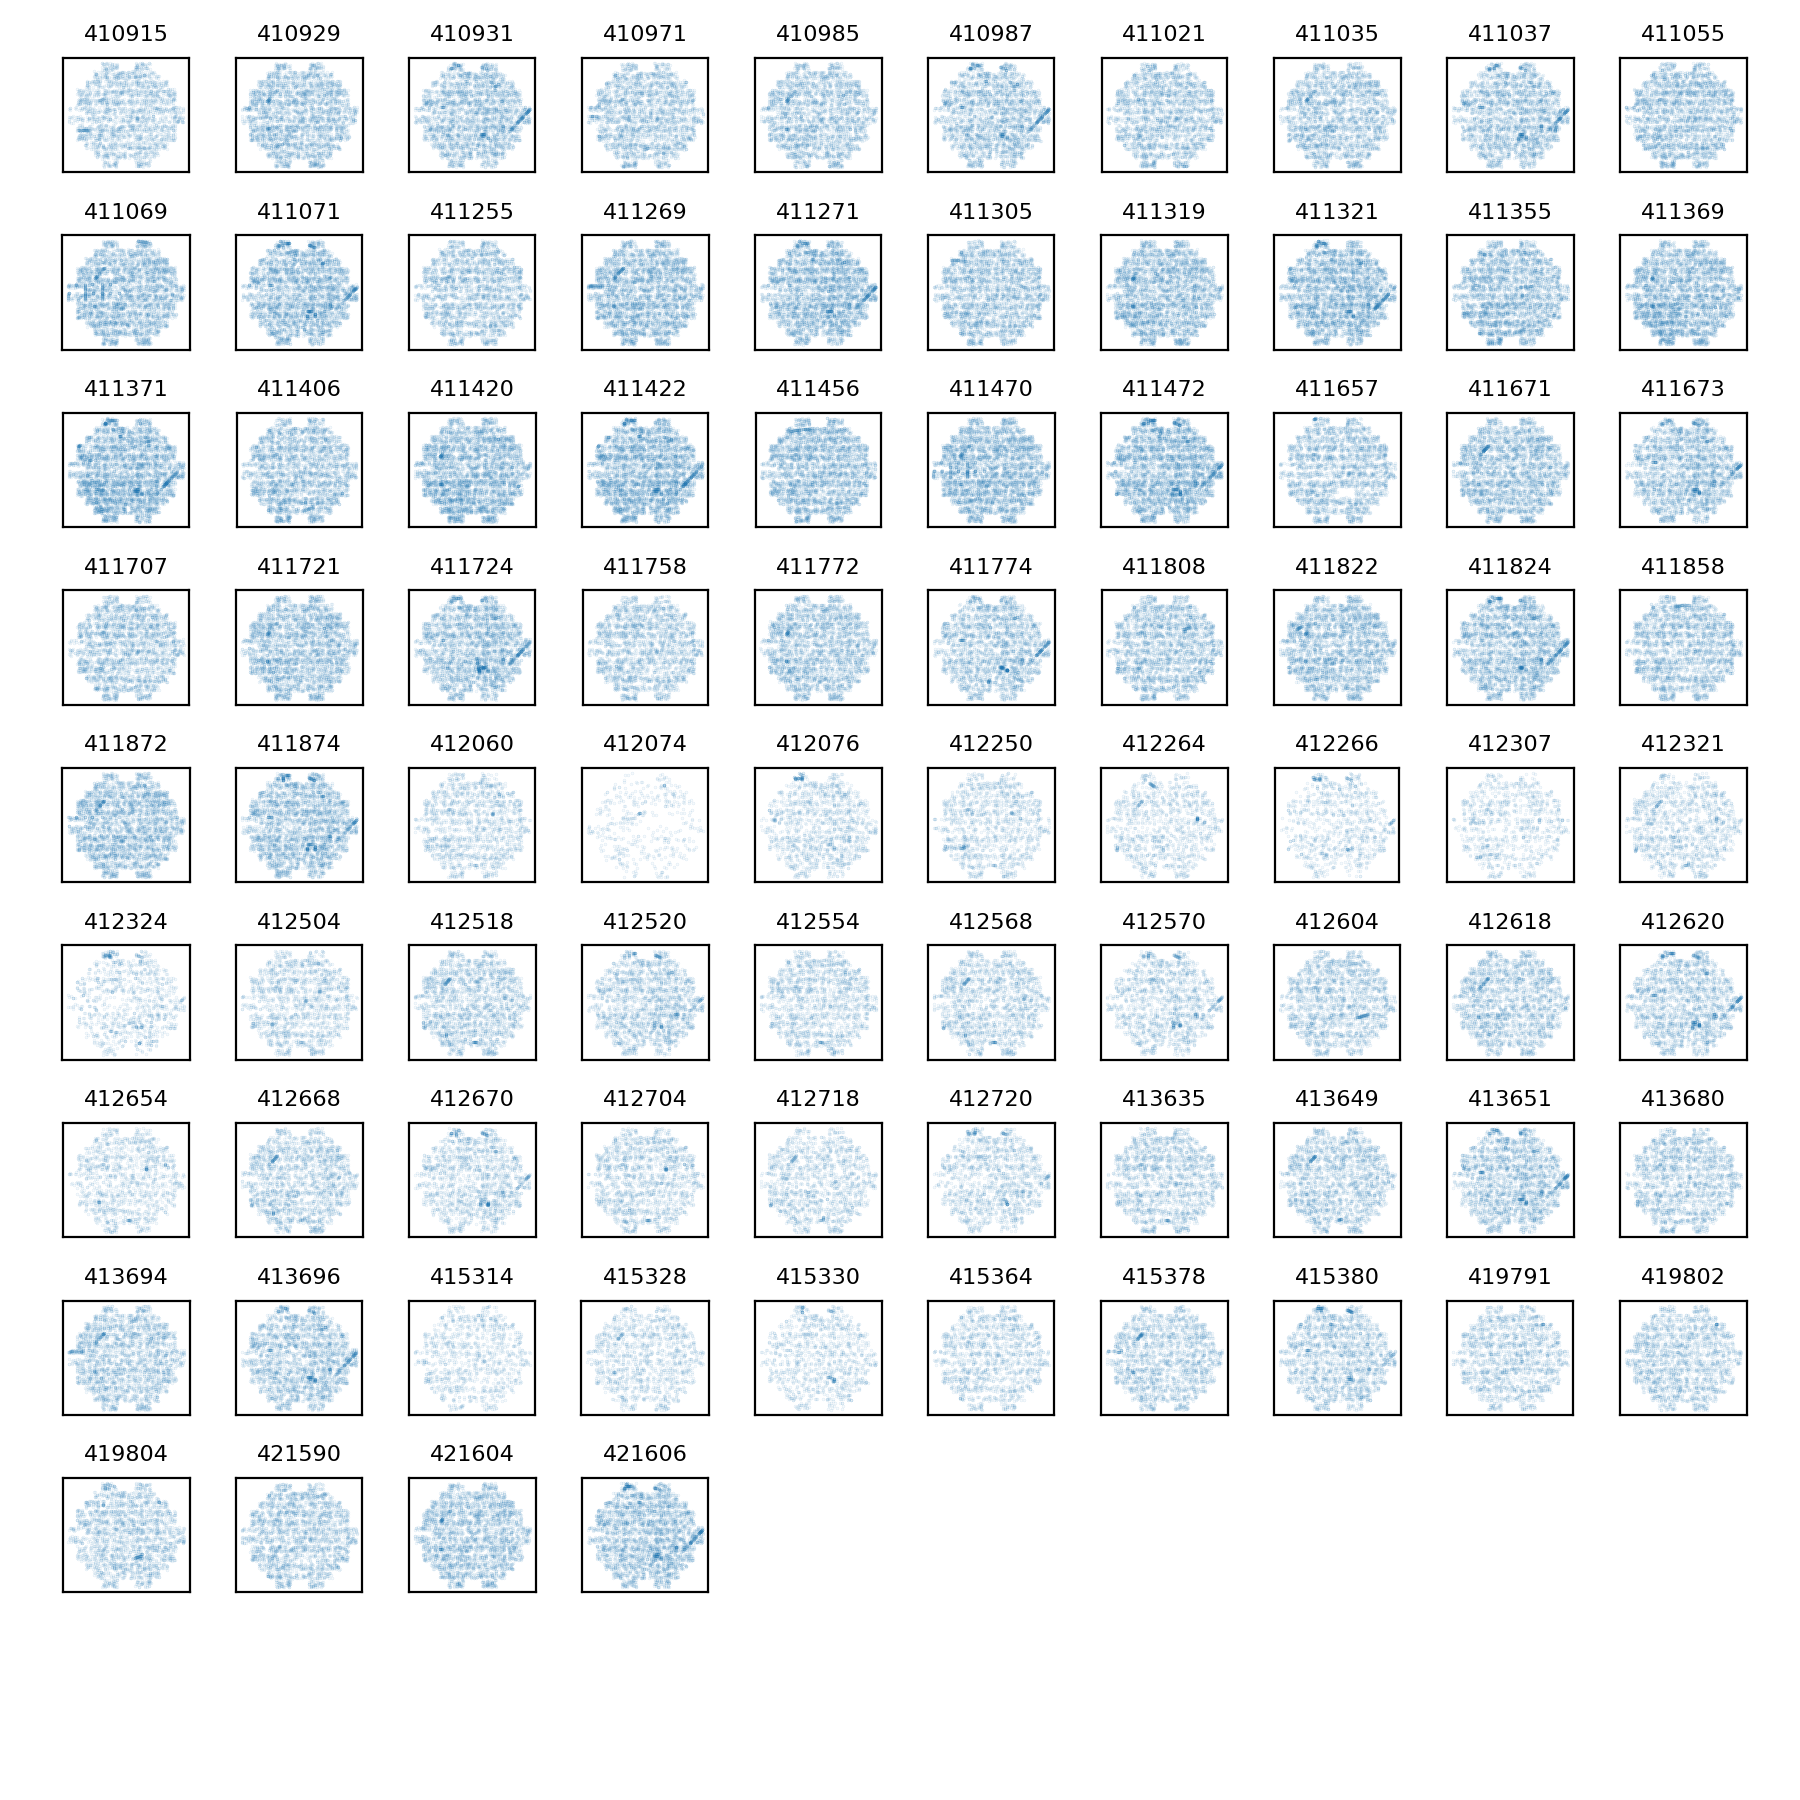

In [10]:
pla.plotDiaSourcesOnSkyGrid(repo, goodSrc)

## Compare to the last rerun from April 2020

In [11]:
repo_old = '/project/mrawls/hits2015/rerun/cw_2020_04'

In [12]:
objTable_old, srcTable_old, goodObj_old, goodSrc_old = pla.loadTables(repo_old)

In [13]:
print(len(srcTable), len(srcTable_old))
print(len(goodSrc), len(goodSrc_old))
print(len(objTable), len(objTable_old))
print(len(goodObj), len(goodObj_old))

669926 618472
228130 210712
246511 176880
58349 48324


<IPython.core.display.Javascript object>


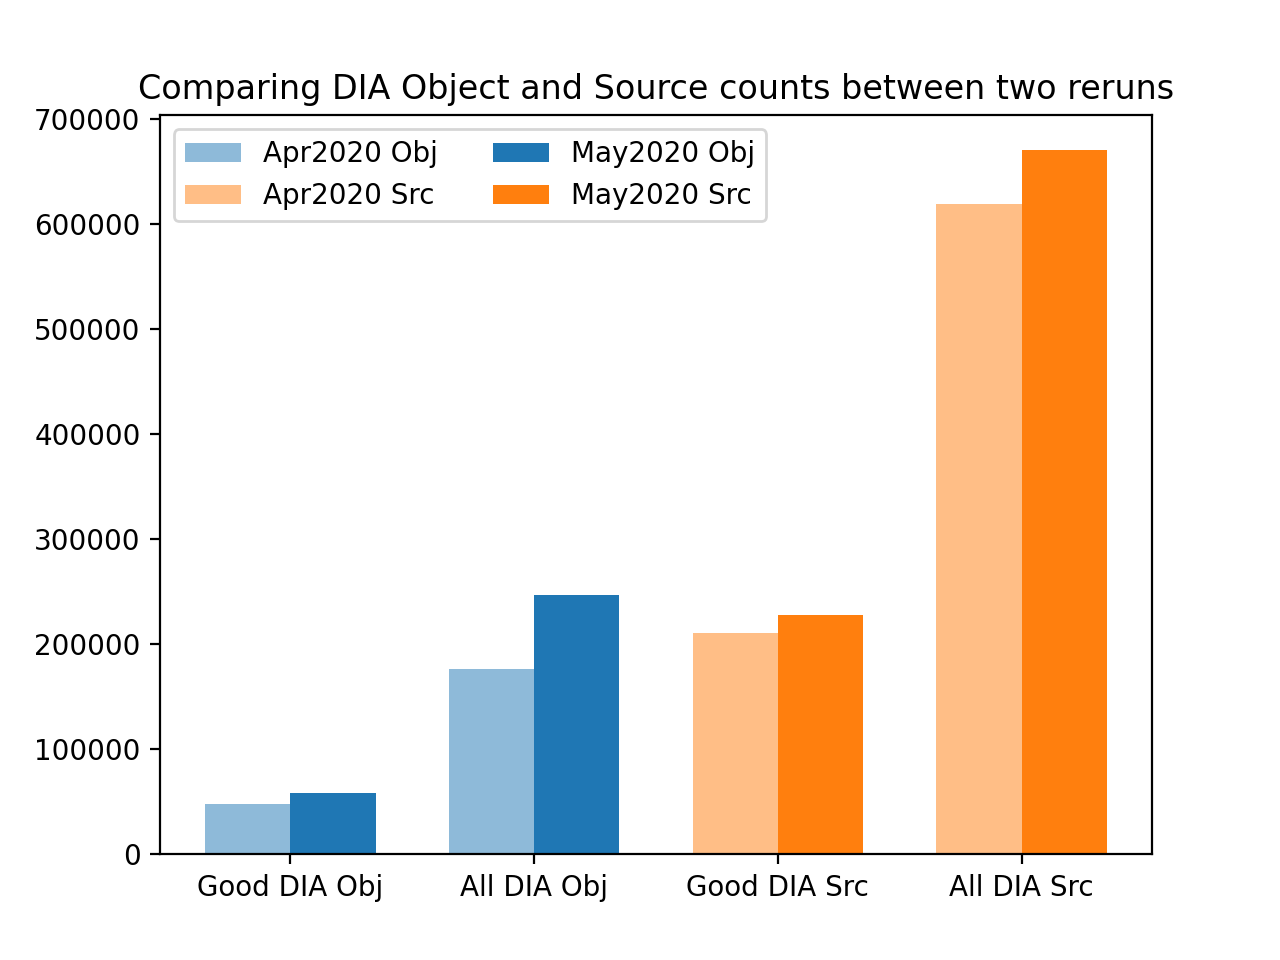

Text(0.5, 1.0, 'Comparing DIA Object and Source counts between two reruns')

In [14]:
srcTable1 = srcTable_old
goodSrc1 = goodSrc_old
objTable1 = objTable_old
goodObj1 = goodObj_old
label1 = "Apr2020"

srcTable2 = srcTable
goodSrc2 = goodSrc
objTable2 = objTable
goodObj2 = goodObj
label2 = "May2020"

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.35

# Old
ax.bar(xbar - width/2, [len(goodObj1), len(objTable1)], 
       width, label=label1 + ' Obj', color='C0', alpha=0.5)
ax.bar(xbar + 2 - width/2, [len(goodSrc1), len(srcTable1)],
       width, label=label1 + ' Src', color='C1', alpha=0.5)

# New
ax.bar(xbar + width/2, [len(goodObj2), len(objTable2)], 
       width, label=label2 + ' Obj', color='C0')
ax.bar(xbar + 2 + width/2, [len(goodSrc2), len(srcTable2)],
       width, label=label2 + ' Src', color='C1')

plt.legend(ncol=2)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title('Comparing DIA Object and Source counts between two reruns')

<IPython.core.display.Javascript object>


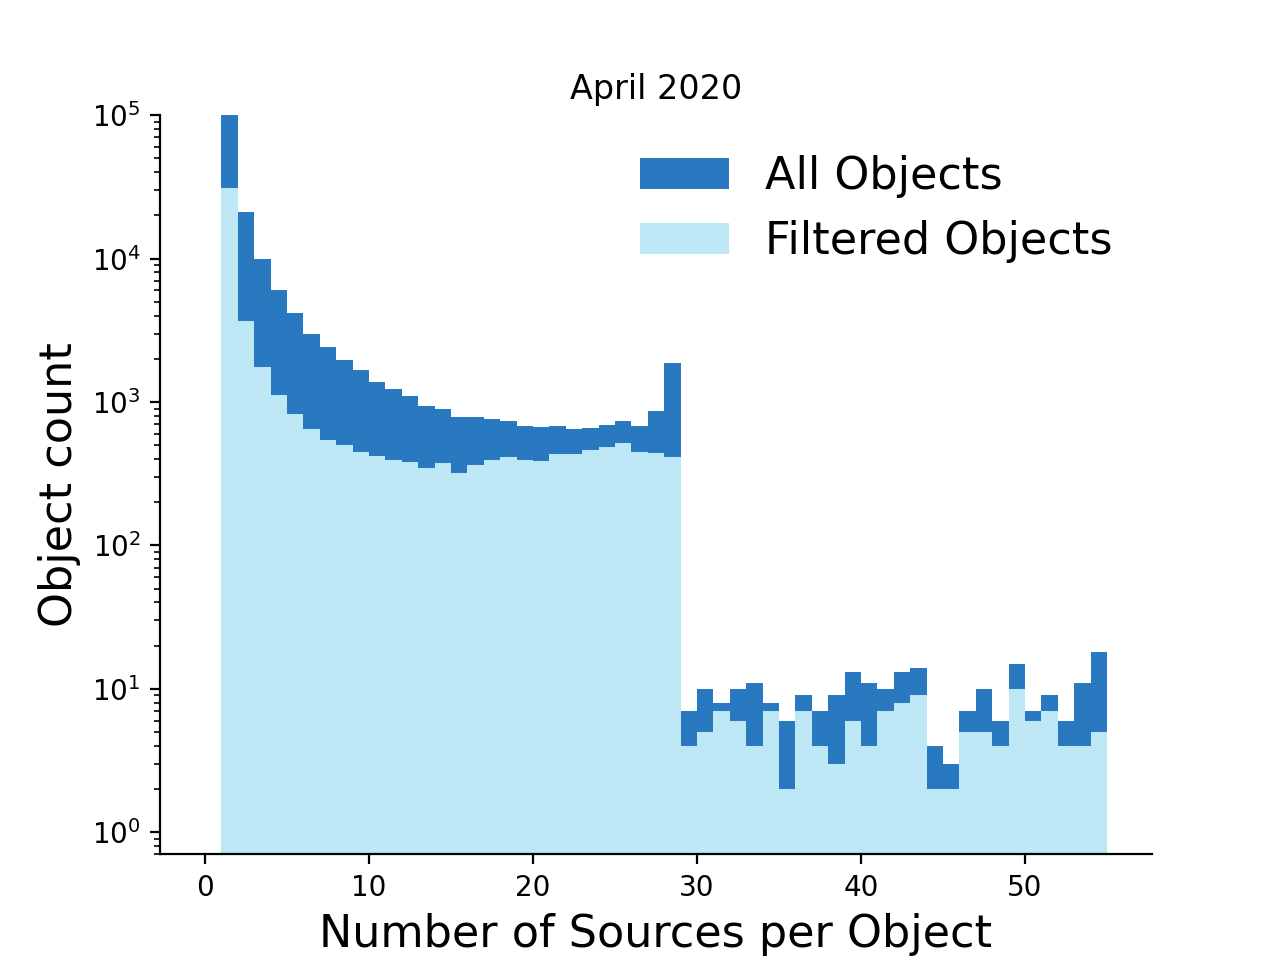

<IPython.core.display.Javascript object>


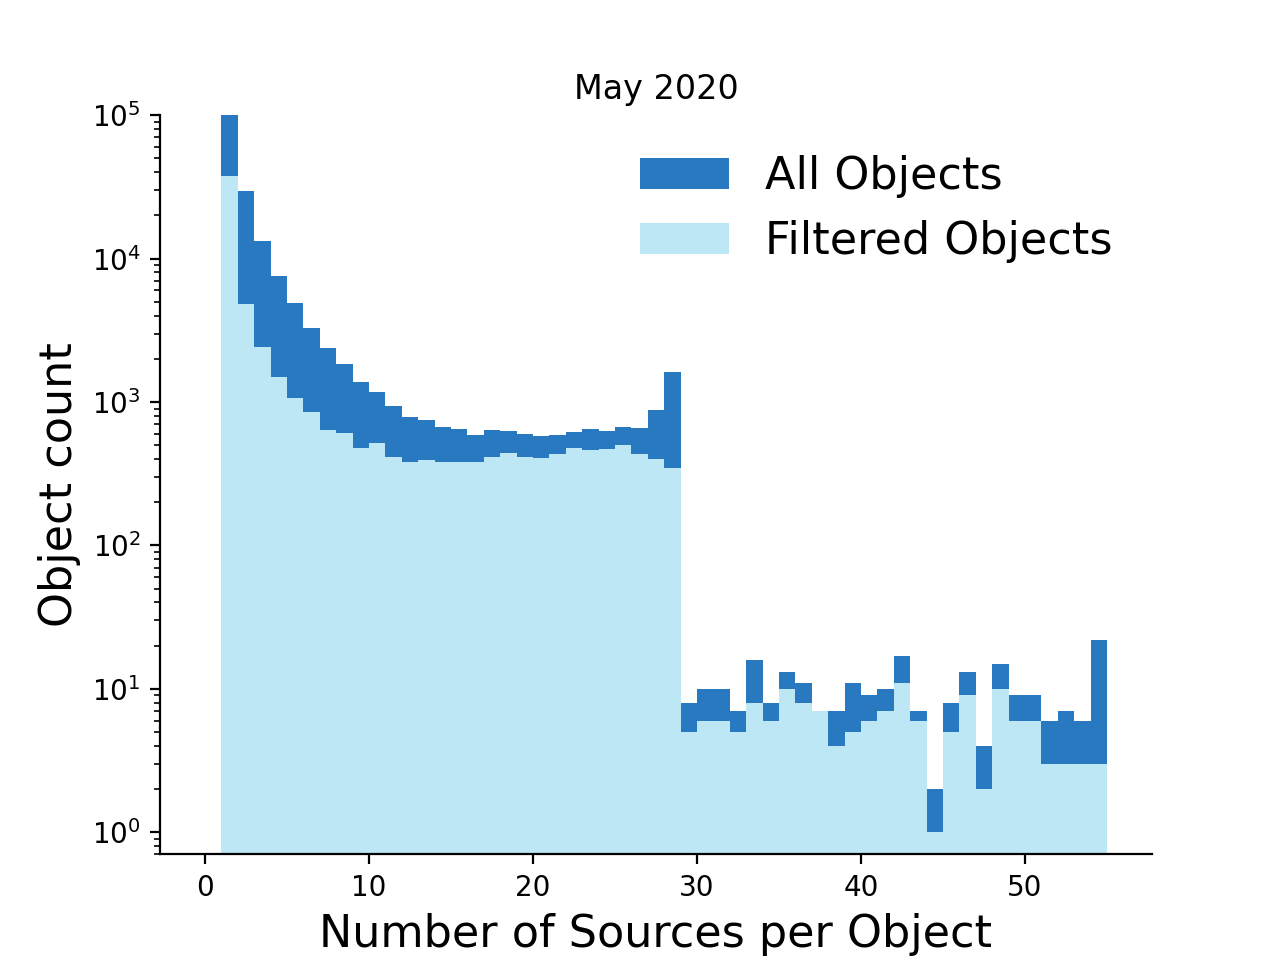

In [15]:
# Side-by-side histogram comparison
histOld = doa.plotDiaObjectHistogram(objTable_old, goodObj_old, title="April 2020")
histNew = hist = doa.plotDiaObjectHistogram(objTable, goodObj, title="May 2020")

## Siegfried asked for some specific data and numbers
I remembered that I had previously made nice magnitude histograms, and should add that to my plotting utilities!

<IPython.core.display.Javascript object>


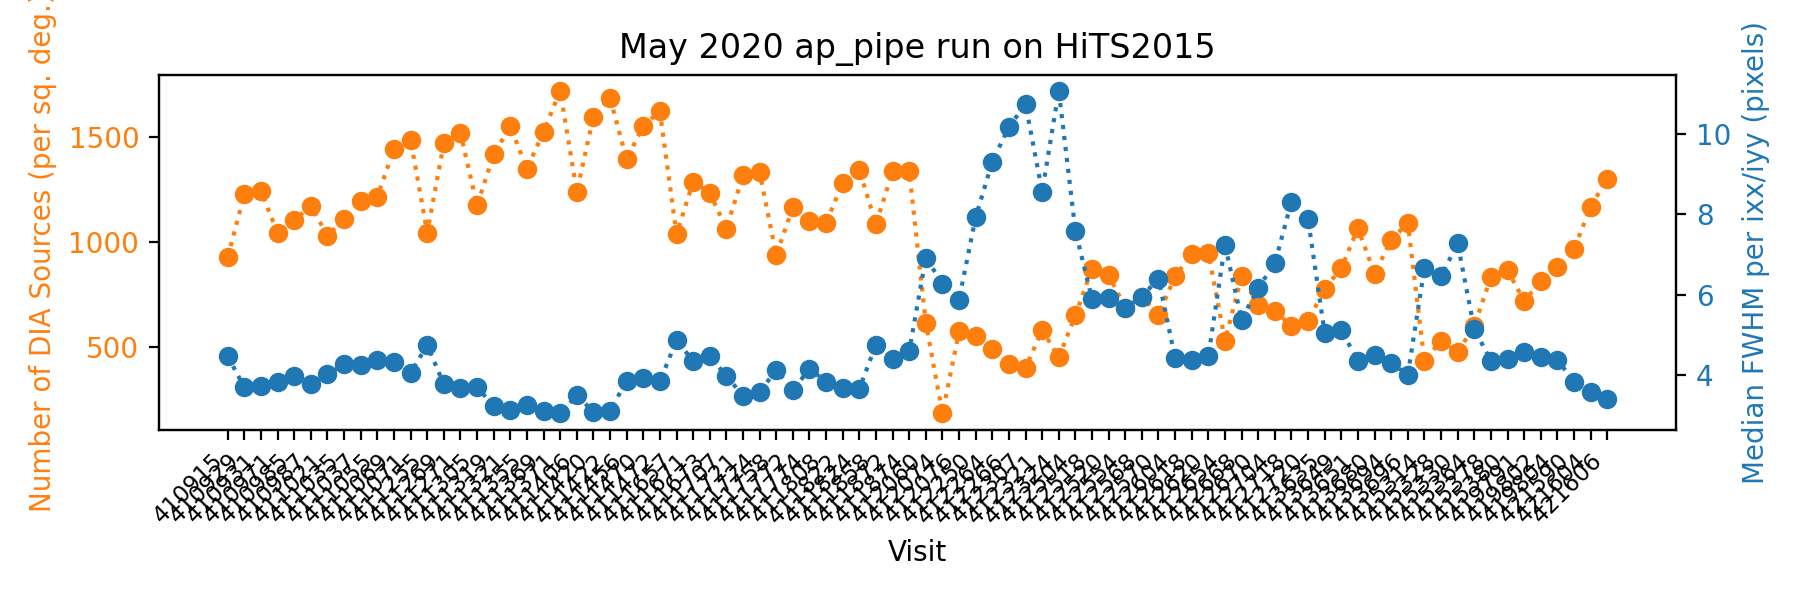

In [16]:
pla.plotDiaSourcesPerVisit(repo, goodSrc, title='May 2020 ap_pipe run on HiTS2015')

<IPython.core.display.Javascript object>


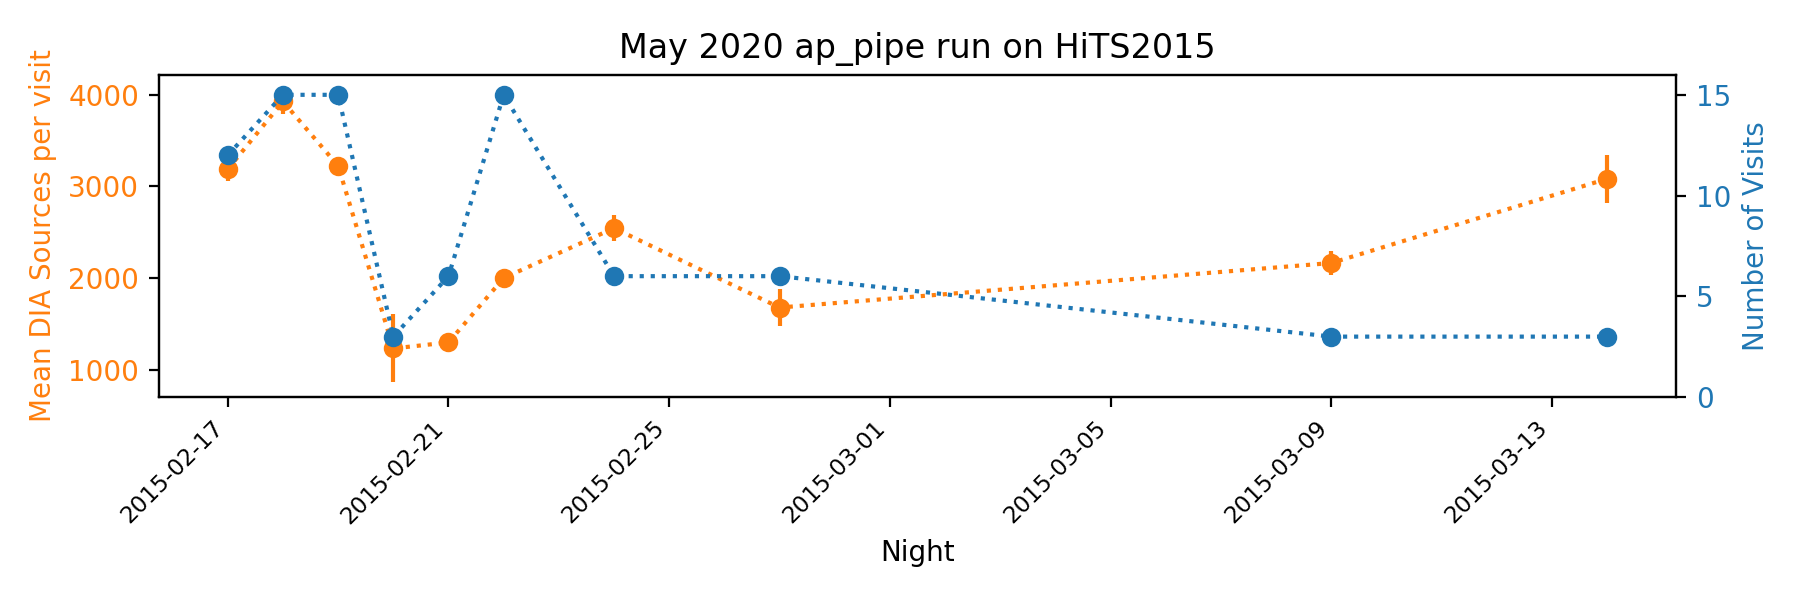

In [17]:
pla.plotDiaSourcesPerNight(goodSrc, title='May 2020 ap_pipe run on HiTS2015')

In [18]:
ccdArea, visitArea = pla.getCcdAndVisitSizeOnSky(repo, goodSrc)
traceRadius = np.sqrt(0.5) * np.sqrt(goodSrc.ixxPSF + goodSrc.iyyPSF)
goodSrc['seeing'] = 2*np.sqrt(2*np.log(2)) * traceRadius
visitGroup = goodSrc.groupby('visit')
visits = visitGroup.visit.first().values
times = visitGroup.midPointTai.first().values
nDiaSourcesPerSqDeg = visitGroup.ccd.count().values/visitArea
medFwhmPerIxxIyy = visitGroup.seeing.median().values

goodSrc['date_time'] = pd.to_datetime(goodSrc.midPointTai, unit='D', origin=pd.Timestamp('1858-11-17'))
goodSrc['date'] = goodSrc['date_time'].dt.date
night_count = goodSrc.groupby(['date', 'visit']).count()
visits_per_night = night_count.groupby('date').count()

In [19]:
perVisitStats = pd.DataFrame([visits, times, nDiaSourcesPerSqDeg, medFwhmPerIxxIyy]).T

In [20]:
perVisitStats.columns = ['visit', 'date', 'nDiaSourcesPerSqDeg', 'medFwhmPerIxxIyy']

In [21]:
perVisitStats

visit     date nDiaSourcesPerSqDeg medFwhmPerIxxIyy
0   410915  57070.1               929.5          4.45882
1   410929  57070.2             1227.95          3.69043
2   410931  57070.2             1241.68          3.72202
3   410971  57070.2             1043.46          3.81233
4   410985  57070.2             1103.22           3.9668
..     ...      ...                 ...              ...
79  419802  57090.2             813.684          4.45319
80  419804  57090.3             879.388          4.37955
81  421590  57095.2             965.507          3.82253
82  421604  57095.2             1167.44           3.5796
83  421606  57095.2             1301.45          3.40067

[84 rows x 4 columns]

In [22]:
#perVisitStats.to_csv('cw_2020_05_perVisitStats.csv')

In [23]:
goodSrc.columns

Index(['diaSourceId', 'diaObjectId', 'ra', 'decl', 'ccdVisitId', 'midPointTai',
       'apFlux', 'psFlux', 'apFluxErr', 'psFluxErr', 'totFlux', 'totFluxErr',
       'x', 'y', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'ccd', 'visit',
       'base_PixelFlags_flag', 'base_PixelFlags_flag_offimage',
       'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
       'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr',
       'base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_interpolatedCenter',
       'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_crCenter',
       'base_PixelFlags_flag_suspectCenter', 'slot_Centroid_flag',
       'slot_Centroid_pos_flag', 'slot_Centroid_neg_flag', 'slot_ApFlux_flag',
       'slot_ApFlux_flag_apertureTruncated', 'slot_PsfFlux_flag',
       'slot_PsfFlux_flag_noGoodPixels', 'slot_PsfFlux_flag_edge',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixel

In [24]:
def plotFluxHistSrc(srcTable1, srcTable2=None, fluxType='psFlux', label1=None, label2=None, title=None, ylog=False):
    plt.figure(figsize=(7, 5))
    plt.xlabel(fluxType, size=12)
    plt.ylabel('DIA Source count', size=12)
    #bins = np.concatenate((-1*np.flip(np.logspace(-1, 6, 50)), np.logspace(-1, 6, 50)))
    bins = np.linspace(-1e4, 1e4, 200)
    if ylog:
        plt.yscale('log')
    #plt.xscale('symlog')
    plt.hist(srcTable1[fluxType].values, bins=bins, color='#2979C1', label=label1)
    if srcTable2 is not None:
        plt.hist(srcTable2[fluxType].values, bins=bins, color='#Bee7F5', label=label2)
    if label1:
        plt.legend(frameon=False, fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.title(title)

<IPython.core.display.Javascript object>


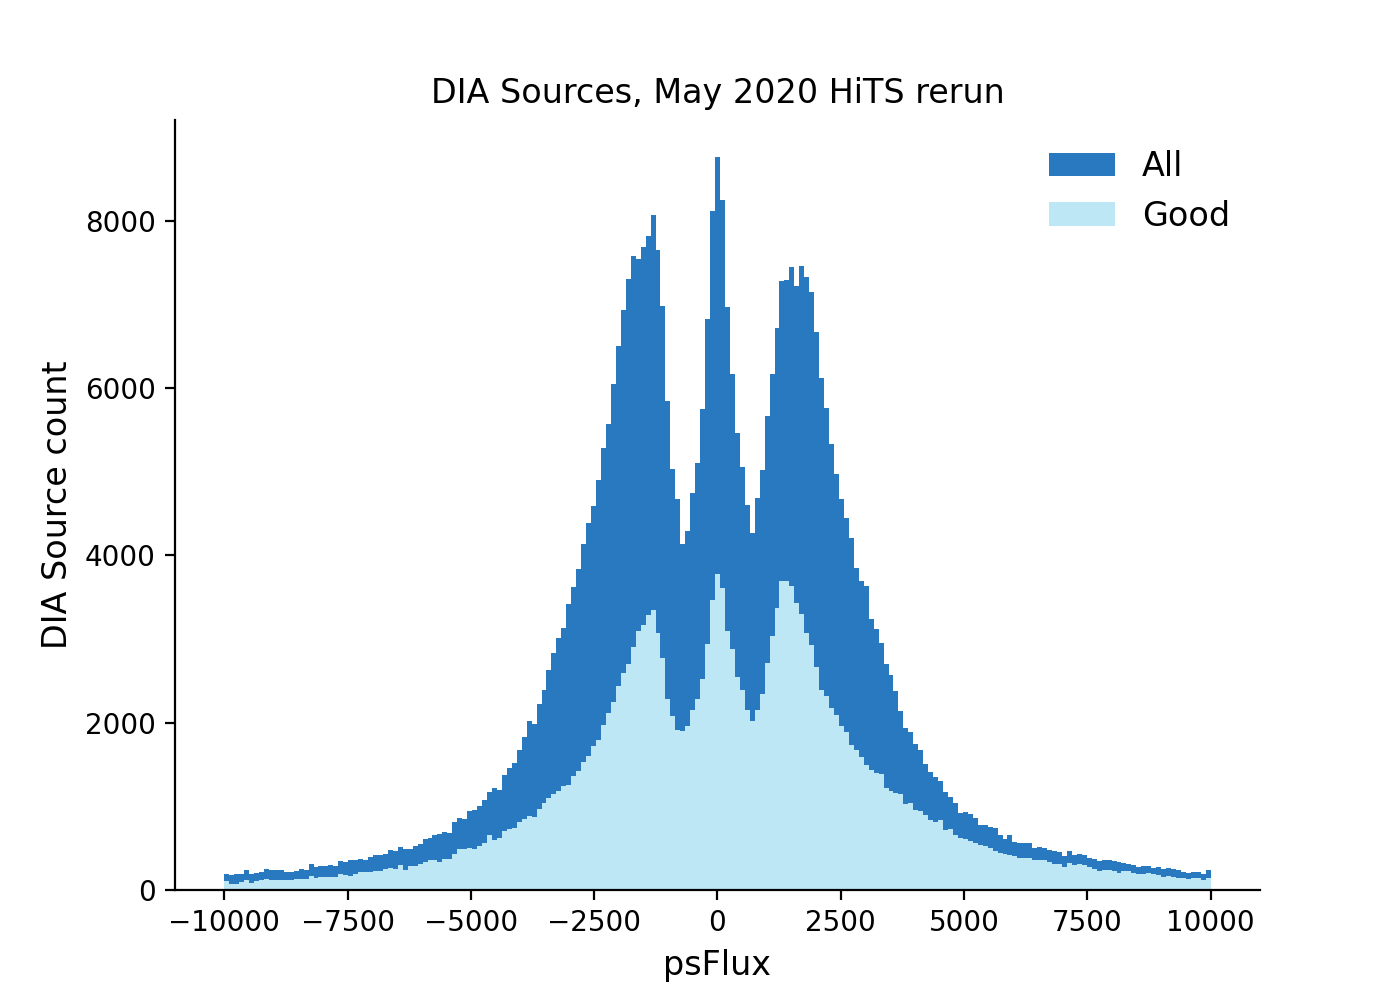

In [25]:
plotFluxHistSrc(srcTable, goodSrc, fluxType='psFlux', label1='All', label2='Good',
                title='DIA Sources, May 2020 HiTS rerun')

<IPython.core.display.Javascript object>


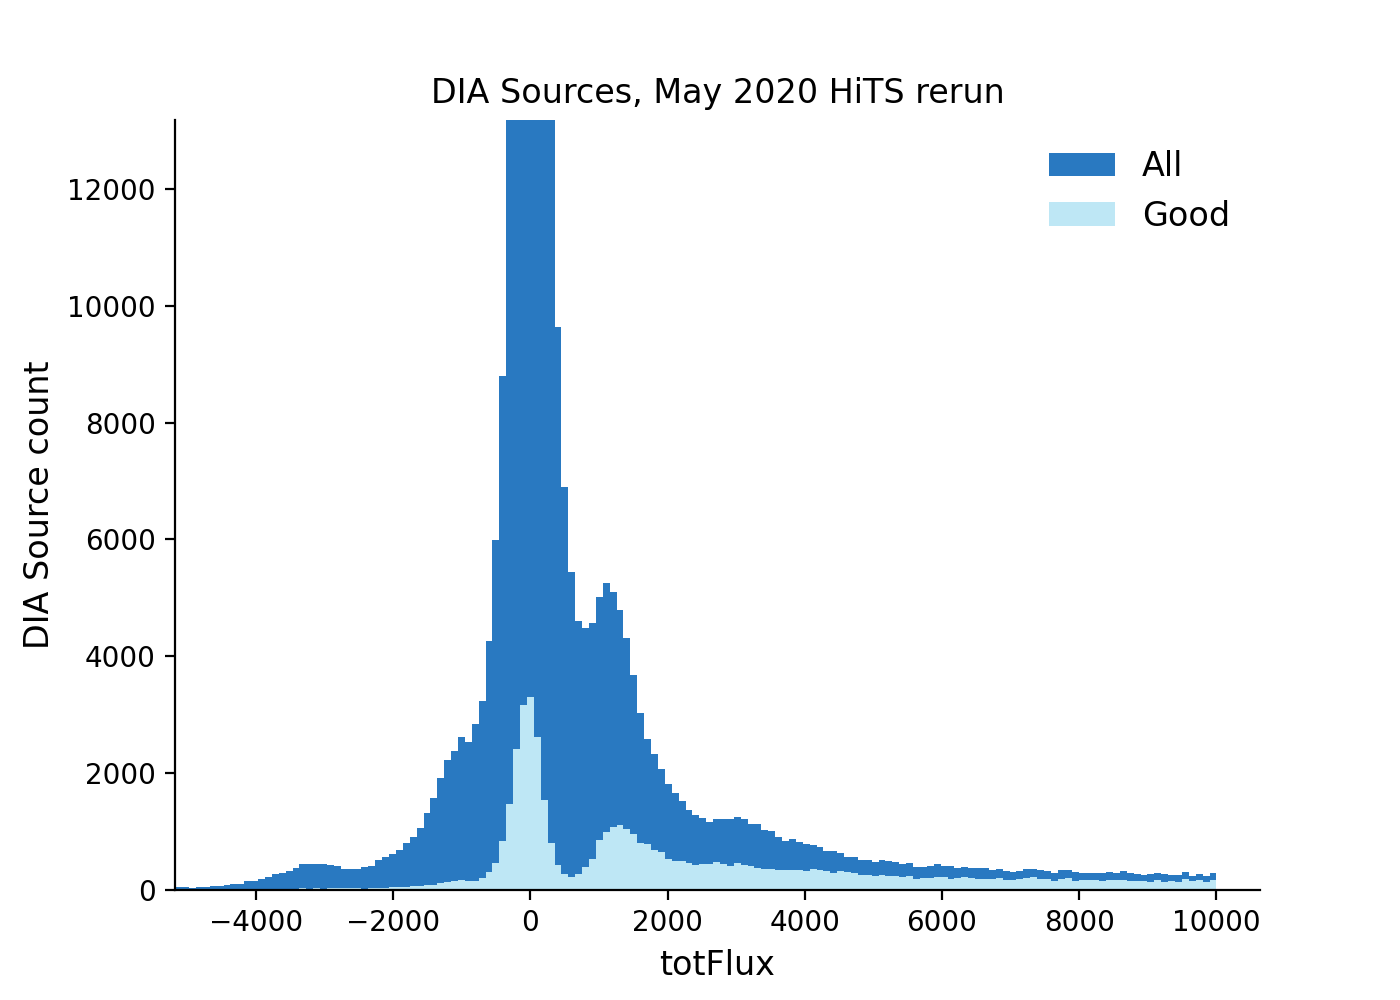

In [26]:
plotFluxHistSrc(srcTable, goodSrc, fluxType='totFlux', label1='All', label2='Good',
                title='DIA Sources, May 2020 HiTS rerun')

In [27]:
#goodSrc.to_csv('cw_2020_05_diaSrcFluxes.csv', columns=['diaSourceId', 'diaObjectId', 'visit', 'ccd',
#                                                       'midPointTai', 'apFlux', 'apFluxErr', 'psFlux',
#                                                       'psFluxErr', 'totFlux', 'totFluxErr', 'seeing'])

## Plots requested by Eric

1. A scatter plot of number of DIA Sources vs seeing

2. Another scatter plot of number of DIA Sources vs (science seeing - template seeing)

In [28]:
ccdArea, visitArea = pla.getCcdAndVisitSizeOnSky(repo, goodSrc)
visitGroup = goodSrc.groupby('visit')

night_count = goodSrc.groupby(['date', 'visit']).count()
visits_per_night = night_count.groupby('date').count()
pervisit_per_night = night_count.groupby('date').mean()
pervisit_per_night_std = night_count.groupby('date').std()
pervisit_per_night_err = pervisit_per_night_std['x']/np.sqrt(visits_per_night['x'])

<IPython.core.display.Javascript object>


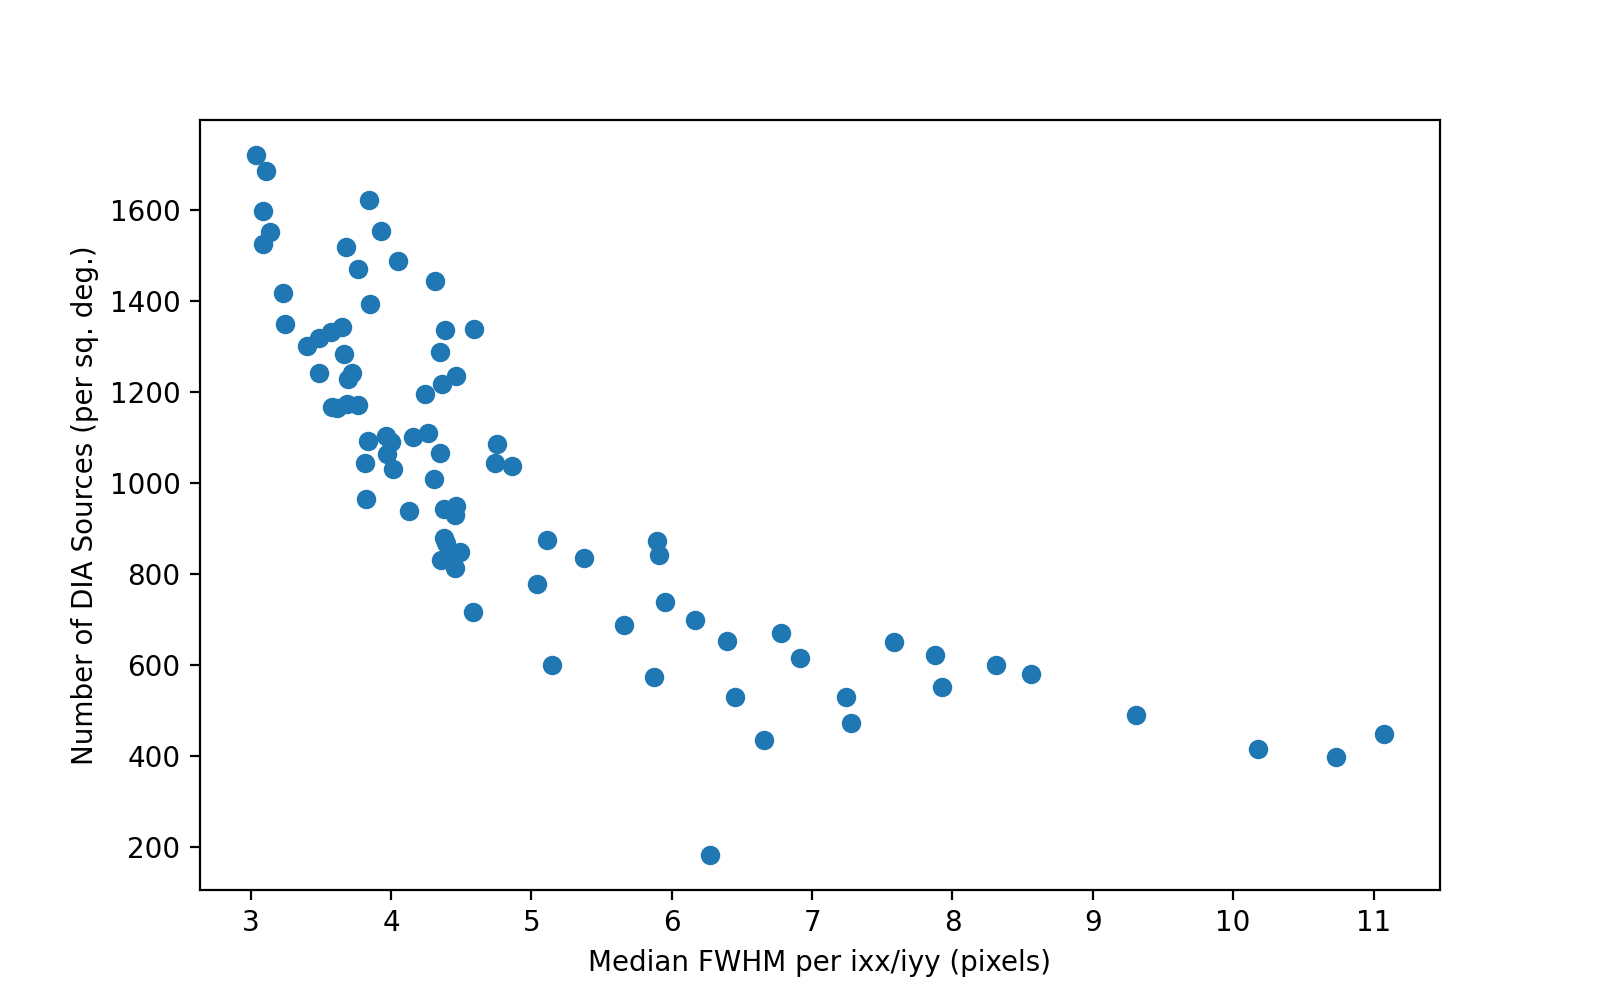

Text(0.5, 0, 'Median FWHM per ixx/iyy (pixels)')

In [29]:
plt.figure(figsize=(8,5))
plt.scatter(visitGroup.seeing.median().values, visitGroup.ccd.count().values/visitArea)
plt.ylabel('Number of DIA Sources (per sq. deg.)')
plt.xlabel('Median FWHM per ixx/iyy (pixels)')

In [30]:
import lsst.ip.diffim
getTemplate = lsst.ip.diffim.GetCoaddAsTemplateTask()

### Diversion into retrieving a template given a calexp which I didn't actually need

In [41]:
testDataId = {'visit': int(goodSrc['visit'].iloc[30]), 'ccd': int(goodSrc['ccd'].iloc[30]), 'filter': 'g'}
#print(testDataId)
ccdDataId = {'ccd': int(goodSrc['ccd'].iloc[0])}
butler = dafPersist.Butler(repo)
testExposure = butler.get('calexp', dataId=testDataId)

skyMap = butler.get(datasetType='deepCoadd_skyMap')
expWcs = testExposure.getWcs()
expBoxD = lsst.geom.Box2D(testExposure.getBBox())
expBoxD.grow(10)
ctrSkyPos = expWcs.pixelToSky(expBoxD.getCenter())
tractInfo = skyMap.findTract(ctrSkyPos)
skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in expBoxD.getCorners()]
patchList = tractInfo.findPatchList(skyCorners)
patchInfo = patchList[0]

templateDataId = dict(tract=tractInfo.getId(),
                      patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                      filter='g')
#print(templateDataId)
sensorRef = butler.dataRef('deepCoadd', **templateDataId)
template = getTemplate.runDataRef(testExposure, sensorRef)
templateExposure = template.exposure

### Retrieve seeing info for all template patches

In [42]:
patchList = ['10,11', '10,12', '10,13', '10,14', '10,15', '11,10', '11,11', '11,12', '11,13',
             '11,14', '11,15', '11,16', '11,6', '11,7', '11,8', '11,9', '12,10', '12,11', '12,12', 
             '12,13', '12,14', '12,15', '12,16', '12,5', '12,6', '12,7', '12,8', '12,9', '13,10',
             '13,11', '13,12', '13,13', '13,14', '13,15', '13,16', '13,4', '13,5', '13,6', '13,7',
             '13,8', '13,9', '14,10', '14,11', '14,12', '14,13', '14,14', '14,15', '14,16', '14,4',
             '14,5', '14,6', '14,7', '14,8', '14,9', '15,10', '15,11', '15,12', '15,13', '15,14',
             '15,15', '15,16', '15,4', '15,5', '15,6', '15,7', '15,8', '15,9', '16,10', '16,11',
             '16,12', '16,13', '16,14', '16,15', '16,4', '16,5', '16,6', '16,7', '16,8', '16,9',
             '17,10', '17,12', '17,13', '17,5', '17,6', '17,7', '17,8', '17,9', '18,6', '18,7',
             '18,8', '18,9', '28,37', '28,38', '29,35', '29,36', '29,37', '29,38', '29,39', '29,40',
             '30,34', '30,35', '30,36', '30,37', '30,38', '30,39', '30,40', '30,41', '31,34',
             '31,35', '31,36', '31,37', '31,38', '31,39', '31,40', '31,41', '32,34', '32,35',
             '32,36', '32,37', '32,38', '32,39', '32,40', '32,41', '33,34', '33,35', '33,36',
             '33,37', '33,38', '33,39', '33,40', '33,41', '34,35', '34,36', '34,37', '34,38',
             '34,39', '34,40', '34,41', '35,36', '35,37', '35,38', '35,39', '36,37', '36,38', '9,12', '9,13']

In [45]:
templateSeeingList = []
for patch in patchList:
    template = butler.get('deepCoadd', dataId={'tract': 0, 'patch': patch, 'filter': 'g'})
    ixxPSF = template.getPsf().computeShape().getIxx()
    iyyPSF = template.getPsf().computeShape().getIyy()
    seeing = 2*np.sqrt(2*np.log(2)) * np.sqrt(0.5) * np.sqrt(ixxPSF + iyyPSF)
    templateSeeingList.append(seeing)

patchList and templateSeeingList are now parallel lists, but should probably really be a dict with the patch as the key and the seeing as the value.

In [47]:
np.median(templateSeeingList)

4.494936985887657

In [48]:
np.std(templateSeeingList)

0.2293150614428702

The template is static in time, so computing science seeing - template seeing just results in an offset. It is more illustrative to show where the template seeing roughly is in comparison to all the science images.

In [50]:
scienceSeeingList = visitGroup.seeing.median().values
scienceMinusTemplateSeeingList = [item - np.median(templateSeeingList) for item in scienceSeeingList]

<IPython.core.display.Javascript object>


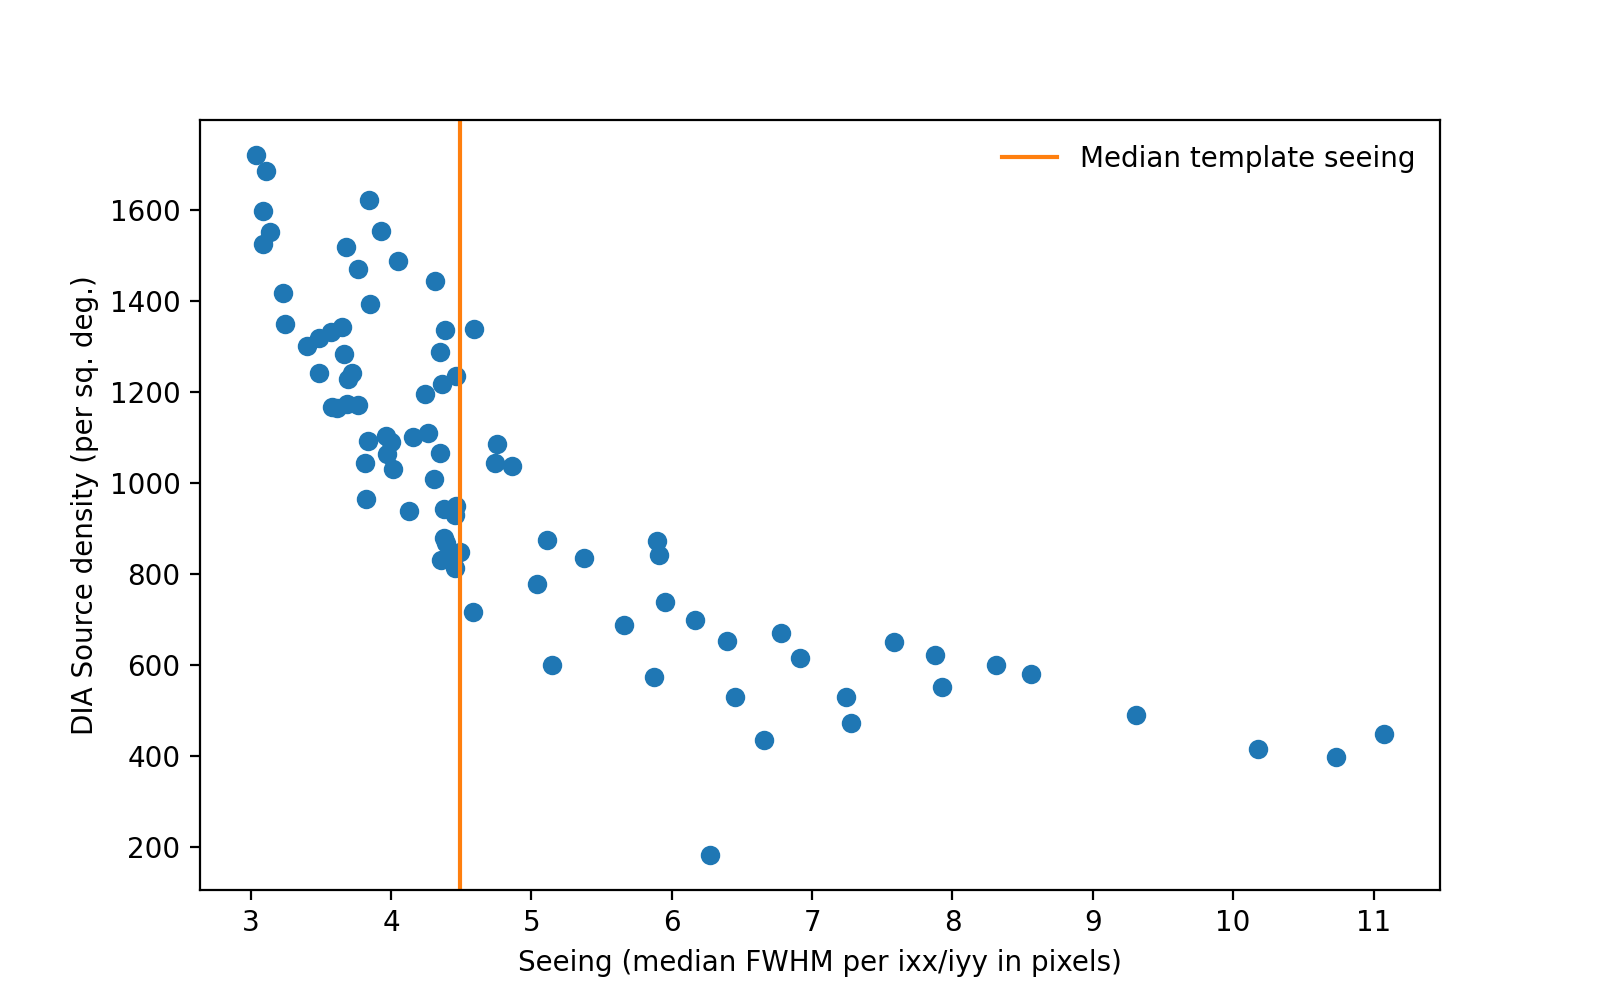

In [56]:
plt.figure(figsize=(8,5))
plt.scatter(visitGroup.seeing.median().values, visitGroup.ccd.count().values/visitArea)
plt.ylabel('DIA Source density (per sq. deg.)')
plt.xlabel('Seeing (median FWHM per ixx/iyy in pixels)')
plt.axvline(np.median(templateSeeingList), color='C1', label='Median template seeing')
plt.legend(frameon=False)